# Ejercicio 1 | CVRPTW   | Cadena de Suministros

#### **Variables de decisión** ####

- $x_{i,j}$ igual a 1 cuando se decide viajar en el arco $(i,j) \in A$; cero de lo contrario

- $u_i$ capacidad $;i \; \in\; C$

#### **Función Objetivo**####
$Min\; z= \; \displaystyle\sum_{i\;\in\;A}^{} \sum_{j\;\in\;A}^{} x_{ij}c_{ij}$

#### **Restricciones**####
$\displaystyle\sum_{i\;\in\;Cliente}^{}x_{ij}=1$   $\; \; \forall \;j \; \in \; Nodos$

$\displaystyle\sum_{j\;\in\;Cliente}^{}x_{ij}=1$   $\; \; \forall \;i \; \in \; Nodos$

$Si \; x_{ij}=1 \Rightarrow u{i}+q_{j}=u{j}$
$\; \; i,j\in Arcos: i \neq0,j\neq0 $

$ q_i\leq u_i \leq Q \; \; i \in Nodos$

### **Formulación matemática del problema**
-cliente (C): Conjunto de **clientes**

-nodos (N) : Conjunto de **nodos**, donde 0 representa del DC |$\;N= \{0\} \cup C $

-arcos (A): Conjunto de todos los **arcos** entre cada nodo |$\;A= \{(i,j) \ in N^2 : i \neq j\}$

-$c_{ij}$ = Costo o distancia entre nodos i y el nodo j

-$q_i$ = carga de cada paquete en Cliente.

-Q: Capacidad de los vehículos.

In [1]:
import gurobipy as gp
from gurobipy import Model, GRB, quicksum
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from geopy import distance #si les arroja error, coloquen en anaconda prompt conda install -c conda-forge geopy

In [2]:
#pip install folium

In [3]:
Q=200
V=10
df=pd.read_excel("Prueba M1.xlsx")
df.set_index('Cliente',inplace=True)
nodos=[a for a in df.index]
clientes=[a for a in nodos if a!=0]
vehiculos=[i for i in range(1,V+1)]
df

,customer_id,lat,lng,type,ready_time,due_date,Service,Demand
Cliente,,,,,,,,
305,///RECREOS SAS,-31.425605,-64.495095,Station,0,300,1,2
319,MAURICIO JAVIER NIETO,-31.307802,-64.462795,Dropoff,0,100,1,2
337,#LOPEZ NELLIDA,-31.408433,-64.473124,Dropoff,0,100,1,2
356,#PACCAZOCCO ANALIA NOEMI,-31.415878,-64.487598,Dropoff,0,100,1,2
362,#BECFUN S.A.,-31.419210,-64.490578,Dropoff,20,200,1,2
...,...,...,...,...,...,...,...,...
389B,CEPROCOR,-31.283796,-64.449259,Dropoff,50,300,1,2
427A,OSDE - URGENCIAS R.NUÑEZ,-31.368211,-64.231891,Dropoff,50,300,1,2
432A,DISP.SANTA MARIA DOMINGO SAVIO,-31.278511,-64.464606,Dropoff,50,300,1,2


In [4]:
#plt.figure(figsize=(200,60)) #tamaño del lienzo donde se grafica
#plt.scatter(df['lat'],df['lng'],c='green') #graficar coordenadas de clientes

#for i in clientes[0:50]:
    #plt.annotate(i,(df['lat'][i]-1,df['lng'][i]-1.5)) #lo que acompaña al "q" es la demanda de cada cliente
    #plt.annotate('$q_{%d}=%d$'%(i,df['Demand'][i]),(df['lat'][i]-1,df['lng'][i]-1.5)) #lo que acompaña al "q" es la demanda de cada cliente
#graficar CD
#plt.plot(df['lat'][0],df['lng'][0],color="red",marker='s',) #marker (cuadrado)
#plt.annotate('CD',(df['lat'][0]+0.5,df['lng'][0]-1))

#Formato al gráfico
#plt.xlabel("Latitud")
#plt.ylabel("Longitud")
#plt.xlim(min(df['lat']),max(df['lat']))
#plt.ylim(min(df['lng']),max(df['lng']))
#plt.title(" Gráfico de Nodos - CVRPTW")
#plt.show()

In [5]:
import folium #Recuerden instalar folium si lo van a usar (colocar en anaconda prompt pip install folium)
from folium import features

mapa = folium.Map(location=[df['lat'].mean(),df['lng'].mean()],zoom_start=10)


fg=folium.FeatureGroup()  
for n in nodos: 
    tooltip = df['customer_id'][n]
    fg.add_child(folium.CircleMarker(location=[df['lat'][n],df['lng'][n]],radius=3,
                                     color='#ff0000',fill = True,fill_color='#ff0000'))
    
    fg.add_child(folium.Marker(location=[df['lat'][n],df['lng'][n]],
                           popup=folium.Popup(str(df['lng'][n])+str(df['lng'][n])),
                           icon=folium.Icon(color='green',
                                            icon_color='white',icon='info-sign'), tooltip=tooltip))
    
mapa.add_child(fg)
mapa

In [6]:
arcos = {(i, j) for i in nodos for j in nodos if i != j} #lista con caminos

In [58]:
arcosVehiculos = {(i, j, k) for i in nodos for j in nodos for k in vehiculos if i != j} #lista con caminos
vehiculosNodos={(k, i) for i in nodos for k in vehiculos} #lista con caminos
distancia = {(i, j): distance.distance((df['lat'][i],df['lng'][i]),(df['lat'][j],df['lng'][j])).km for i,j in arcos} # Matriz de distancias
tiempo = {(i, j): distancia[i,j]+ df['Service'][j] for i,j in arcos}
tiempo

{(7, 3): 60.674075997391085,
 (16, 9): 41.163635793787186,
 (19, 4): 21.047858224346726,
 (17, 20): 70.65455647210453,
 (20, 7): 40.94775463162323,
 (18, 19): 32.199866438612126,
 (8, 5): 30.29520512910067,
 (9, 0): 24.48902966719044,
 (10, 7): 40.904347233587316,
 (0, 17): 43.707142319077064,
 (14, 1): 40.1424885500607,
 (12, 17): 40.7326836833634,
 (15, 4): 21.00454216564692,
 (13, 20): 70.38635936247402,
 (3, 2): 40.52390699814792,
 (4, 5): 30.9027840492895,
 (16, 0): 24.610515583382035,
 (19, 13): 40.81734186053331,
 (17, 13): 40.63551465659945,
 (20, 14): 46.31592534422067,
 (18, 10): 41.15030543266332,
 (8, 12): 12.42279793162933,
 (10, 14): 45.68962918285427,
 (8, 18): 34.26663207906875,
 (11, 15): 40.5873617420677,
 (9, 19): 33.248096962742856,
 (14, 8): 24.16221593997768,
 (12, 8): 23.42279793162933,
 (15, 13): 40.693401725882076,
 (2, 18): 34.23963029276878,
 (0, 14): 48.92910154487658,
 (3, 11): 40.59447158138208,
 (1, 15): 40.419334614683784,
 (4, 12): 13.13872895838271,
 (

## Creación y Optimización - CVRPTW ##

In [59]:
m=Model('CVRPTW')

Academic license - for non-commercial use only - expires 2021-06-20
Using license file C:\Users\jplop\gurobi.lic


#### **Variables de decisión** ####

- $x_{i,j}$ igual a 1 cuando se decide viajar en el arco $(i,j) \in A$; cero de lo contrario

- $u_i$ capacidad $;i \; \in\; C$

In [60]:
x=m.addVars(arcosVehiculos,vtype=GRB.BINARY)
t=m.addVars(vehiculosNodos,vtype=GRB.CONTINUOUS)

#### **Función Objetivo** ####
$Min\; z= \; \displaystyle\sum_{i\;\in\;A}^{} \sum_{j\;\in\;A}^{} x_{ij}c_{ij}$

In [61]:
obj=quicksum(distancia[i,j]*x[i,j,k] for i, j, k in arcosVehiculos)
m.setObjective(obj,GRB.MINIMIZE)

#### **Restricciones** 
$\displaystyle\sum_{i\;\in\;Cliente}^{}x_{ij}=1$   $\; \; \forall \;j \; \in \; Nodos$

$\displaystyle\sum_{j\;\in\;Cliente}^{}x_{ij}=1$   $\; \; \forall \;i \; \in \; Nodos$

$Si \; x_{ij}=1 \Rightarrow u{i}+q_{j}=u{j}$
$\; \; i,j\in Arcos: i \neq0,j\neq0 $

$ q_i\leq u_i \leq Q \; \; i \in Nodos$

In [62]:
#Un vehiculo por nodo
m.addConstrs(quicksum(x[i, j, k] for j in nodos for k in vehiculos if j != i) == 1 for i in clientes)
m.addConstrs(quicksum(x[i, j, k] for i in nodos for k in vehiculos if j != i) == 1 for j in clientes)

{1: <gurobi.Constr *Awaiting Model Update*>,
 2: <gurobi.Constr *Awaiting Model Update*>,
 3: <gurobi.Constr *Awaiting Model Update*>,
 4: <gurobi.Constr *Awaiting Model Update*>,
 5: <gurobi.Constr *Awaiting Model Update*>,
 6: <gurobi.Constr *Awaiting Model Update*>,
 7: <gurobi.Constr *Awaiting Model Update*>,
 8: <gurobi.Constr *Awaiting Model Update*>,
 9: <gurobi.Constr *Awaiting Model Update*>,
 10: <gurobi.Constr *Awaiting Model Update*>,
 11: <gurobi.Constr *Awaiting Model Update*>,
 12: <gurobi.Constr *Awaiting Model Update*>,
 13: <gurobi.Constr *Awaiting Model Update*>,
 14: <gurobi.Constr *Awaiting Model Update*>,
 15: <gurobi.Constr *Awaiting Model Update*>,
 16: <gurobi.Constr *Awaiting Model Update*>,
 17: <gurobi.Constr *Awaiting Model Update*>,
 18: <gurobi.Constr *Awaiting Model Update*>,
 19: <gurobi.Constr *Awaiting Model Update*>,
 20: <gurobi.Constr *Awaiting Model Update*>}

In [63]:
#Salir y llegar al CD
m.addConstrs(quicksum(x[0, j, k] for j in clientes if j!= 0) <= 1 for k in vehiculos)
m.addConstrs(quicksum(x[i, 0, k] for i in clientes  if i!= 0) <= 1 for k in vehiculos)

{1: <gurobi.Constr *Awaiting Model Update*>,
 2: <gurobi.Constr *Awaiting Model Update*>,
 3: <gurobi.Constr *Awaiting Model Update*>,
 4: <gurobi.Constr *Awaiting Model Update*>,
 5: <gurobi.Constr *Awaiting Model Update*>,
 6: <gurobi.Constr *Awaiting Model Update*>,
 7: <gurobi.Constr *Awaiting Model Update*>,
 8: <gurobi.Constr *Awaiting Model Update*>,
 9: <gurobi.Constr *Awaiting Model Update*>,
 10: <gurobi.Constr *Awaiting Model Update*>}

In [64]:
m.addConstrs(t[k,i]<=df['due_date'][i] for i in clientes for k in vehiculos)
m.addConstrs(t[k,i]>=df['ready_time'][i] for i in clientes for k in vehiculos)

{(1, 1): <gurobi.Constr *Awaiting Model Update*>,
 (1, 2): <gurobi.Constr *Awaiting Model Update*>,
 (1, 3): <gurobi.Constr *Awaiting Model Update*>,
 (1, 4): <gurobi.Constr *Awaiting Model Update*>,
 (1, 5): <gurobi.Constr *Awaiting Model Update*>,
 (1, 6): <gurobi.Constr *Awaiting Model Update*>,
 (1, 7): <gurobi.Constr *Awaiting Model Update*>,
 (1, 8): <gurobi.Constr *Awaiting Model Update*>,
 (1, 9): <gurobi.Constr *Awaiting Model Update*>,
 (1, 10): <gurobi.Constr *Awaiting Model Update*>,
 (2, 1): <gurobi.Constr *Awaiting Model Update*>,
 (2, 2): <gurobi.Constr *Awaiting Model Update*>,
 (2, 3): <gurobi.Constr *Awaiting Model Update*>,
 (2, 4): <gurobi.Constr *Awaiting Model Update*>,
 (2, 5): <gurobi.Constr *Awaiting Model Update*>,
 (2, 6): <gurobi.Constr *Awaiting Model Update*>,
 (2, 7): <gurobi.Constr *Awaiting Model Update*>,
 (2, 8): <gurobi.Constr *Awaiting Model Update*>,
 (2, 9): <gurobi.Constr *Awaiting Model Update*>,
 (2, 10): <gurobi.Constr *Awaiting Model Update*>

In [65]:
#Conservación del flujos
m.addConstrs(quicksum(x[h, j, k] for j in nodos if j != h)-quicksum(x[i, h, k] for i in nodos if i!= h) == 0 for h in clientes for k in vehiculos)

#Capacidad del vehiculo
m.addConstrs(quicksum(df['Demand'][i]*x[i, j, k] for i in clientes for j in nodos if j != i) <= Q for k in vehiculos)

#Ventanas de tiempo
m.addConstrs((t[k,i] + tiempo[i,j] - 2000*(1 - x[i,j,k]) <= t[k,j]) for i in clientes for j in clientes for k in vehiculos if i != j)

{(1, 2, 1): <gurobi.Constr *Awaiting Model Update*>,
 (1, 2, 2): <gurobi.Constr *Awaiting Model Update*>,
 (1, 2, 3): <gurobi.Constr *Awaiting Model Update*>,
 (1, 2, 4): <gurobi.Constr *Awaiting Model Update*>,
 (1, 2, 5): <gurobi.Constr *Awaiting Model Update*>,
 (1, 2, 6): <gurobi.Constr *Awaiting Model Update*>,
 (1, 2, 7): <gurobi.Constr *Awaiting Model Update*>,
 (1, 2, 8): <gurobi.Constr *Awaiting Model Update*>,
 (1, 2, 9): <gurobi.Constr *Awaiting Model Update*>,
 (1, 2, 10): <gurobi.Constr *Awaiting Model Update*>,
 (1, 3, 1): <gurobi.Constr *Awaiting Model Update*>,
 (1, 3, 2): <gurobi.Constr *Awaiting Model Update*>,
 (1, 3, 3): <gurobi.Constr *Awaiting Model Update*>,
 (1, 3, 4): <gurobi.Constr *Awaiting Model Update*>,
 (1, 3, 5): <gurobi.Constr *Awaiting Model Update*>,
 (1, 3, 6): <gurobi.Constr *Awaiting Model Update*>,
 (1, 3, 7): <gurobi.Constr *Awaiting Model Update*>,
 (1, 3, 8): <gurobi.Constr *Awaiting Model Update*>,
 (1, 3, 9): <gurobi.Constr *Awaiting Model Up

In [66]:
m.Params.TimeLimit = 120  #límite de tiempo (segundos)
m.optimize()

Changed value of parameter TimeLimit to 120.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 4470 rows, 4410 columns and 32200 nonzeros
Model fingerprint: 0x9f54269c
Variable types: 210 continuous, 4200 integer (4200 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+03]
  Objective range  [7e-02, 5e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+03]
Found heuristic solution: objective 78.4503742
Presolve removed 510 rows and 120 columns
Presolve time: 0.04s
Presolved: 3960 rows, 4290 columns, 30920 nonzeros
Variable types: 200 continuous, 4090 integer (4090 binary)

Root relaxation: objective 4.714644e+00, 89 iterations, 0.01 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0    4.71

In [67]:
arcos_activos=[z for z in arcosVehiculos if x[z].x> 0.99] #con el .x se llama a la solución. En cplex es .solution_value 
arcos_activos

[(9, 4, 5),
 (0, 6, 8),
 (2, 8, 6),
 (5, 17, 1),
 (13, 18, 6),
 (14, 16, 8),
 (0, 12, 6),
 (11, 0, 1),
 (0, 5, 1),
 (3, 9, 5),
 (20, 19, 5),
 (1, 14, 8),
 (18, 0, 6),
 (12, 2, 6),
 (16, 10, 8),
 (6, 1, 8),
 (15, 7, 1),
 (4, 20, 5),
 (10, 0, 8),
 (8, 13, 6),
 (17, 15, 1),
 (7, 11, 1),
 (19, 0, 5),
 (0, 3, 5)]

In [68]:
m.objVal

34.99699307703598

In [72]:
mapa = folium.Map(location=[df['lat'].mean(),df['lng'].mean()],zoom_start=14)
color_plot ={0:'#2d89ef',1:'#99b433',2:'#ff0097',3:'#ffc40d',4:'#603cba',5:'#b91d47',
             6:'#9f00a7',7:'#da532c',8:'#2b5797',9:'#e3a21a'}

fg=folium.FeatureGroup()  
for n in nodos: 
    fg.add_child(folium.CircleMarker(location=[df['lat'][n],df['lng'][n]],radius=3,
                                     color='#ff0000',fill = True,fill_color='#ff0000'))
    
    fg.add_child(folium.Marker(location=[df['lat'][n],df['lng'][n]],
                           popup=folium.Popup(str(df['lat'][n])+str(df['lng'][n])),
                           icon=folium.Icon(color='green',
                                            icon_color='white',icon='info-sign')))
    
mapa.add_child(fg)


for i,j,k in arcos_activos:  
    my_PolyLine = folium.PolyLine([(df['lat'][i],df['lng'][i]),
                                  (df['lat'][j],df['lng'][j])], 
                                  color=color_plot[k], weight=2.5, opacity=1).add_to(mapa)
    mapa.add_child(my_PolyLine)
mapa


<function matplotlib.pyplot.show(*args, **kw)>

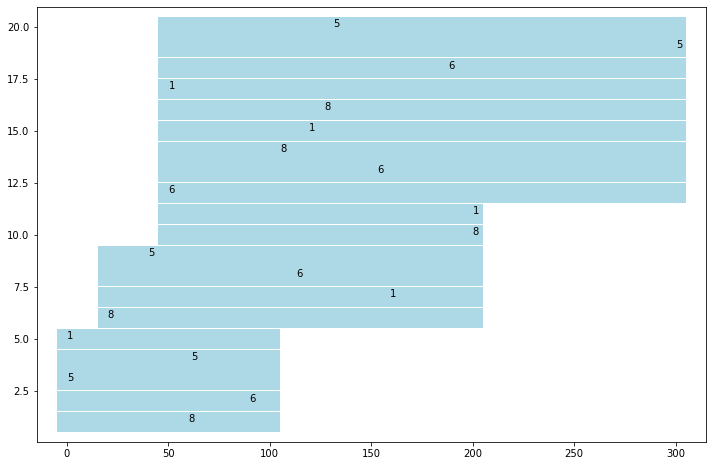

In [75]:
plt.figure(figsize=(12,8))
#plt.scatter(loc_x,loc_y,c='g')
for i in clientes:
    for j in nodos:
        if i != j:
            for k in vehiculos:
                if x[i,j,k].x>0.9:
                    plt.plot([df['ready_time'][i],df['due_date'][i]],[i,i],color='lightblue',alpha=1,linewidth=20)
                    #plt.plot([int(t[k,i].x),int(t[k,j].x)],[i,i],color='red',alpha=1,linewidth=10)
                    plt.annotate(k,(int(t[k,i].x),i))
                    #plt.annotate(j,(int(t[k,j].x),k))
                    #plt.annotate("Vehiculo "+str(k),((df['READY TIME'][j]+df['DUE DATE'][j])/2-20,j),)
                    #plt.annotate("Aircraft "+str(i),((df['READY TIME'][i]+df['DUE DATE'][i])/2-30,i-0.7))
#plt.ylim(-1,9)
#plt.savefig("Schedulling")
plt.show

In [19]:
for i in clientes:
    for k in vehiculos:
        if t[k,i].x>0 :
            if t[k,i].x<df['READY TIME'][i]:
                print(i,k)
                print(df['READY TIME'][i],t[i,k].x,df['DUE DATE'][i])
            elif t[k,i].x>df['DUE DATE'][i]:
                print(i,k)
                print(df['READY TIME'][i],t[i,k].x,df['DUE DATE'][i])